In [1]:
import time, os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from get_dataset import load_dataset
from get_dataset import get_trainset
from get_dataset import scaler_user
from embedding import embedding_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics as MET

(13392, 11)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
lr = 0.00003
epochs = 300
batch_size = 64

In [3]:
created_time = int(time.time()) 
chest_list, chest_dataset = load_dataset('exercise')
user_dataset = scaler_user(load_dataset('user'))

num_chest_dataset = len(chest_dataset[0])
num_user_dataset = len(user_dataset[0])

In [4]:
user_train_input, chest_train_input, chest_label = get_trainset(user_dataset, chest_list, chest_dataset)
print(np.shape(user_train_input),np.shape(chest_train_input),np.shape(chest_label))

(200880, 11) (200880,) (200880,)


In [5]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.00001, patience=5, verbose=1, mode='min',
    baseline=None, restore_best_weights=True
)

KerasTensor(type_spec=TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), name='multiply/mul:0', description="created by layer 'multiply'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 11)        176         ['item_input[0][0]']             
                                                                                                  
 user_unput (InputLayer)        [(None, 11)]         0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 11)    

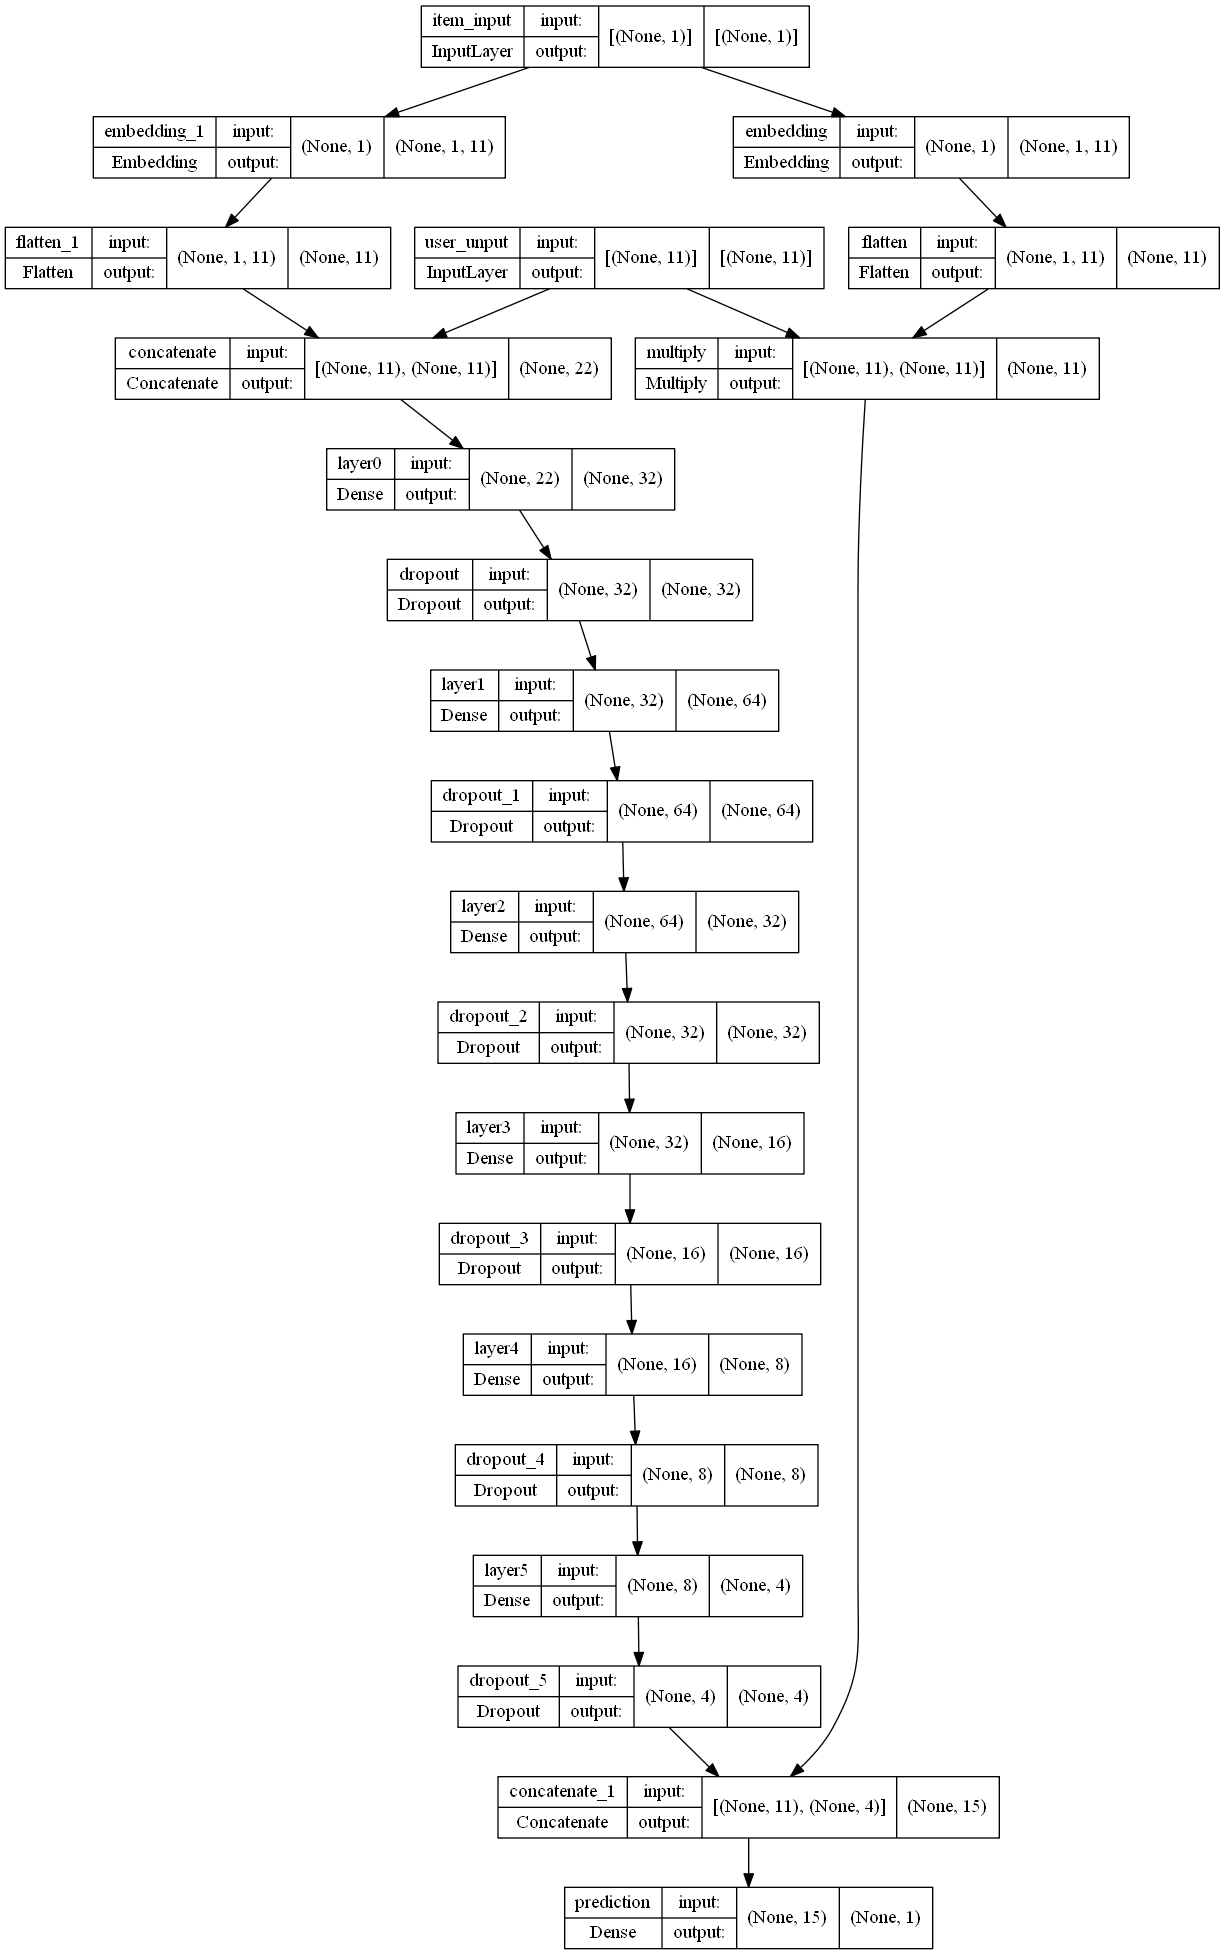

In [6]:
model = embedding_model(num_user_dataset,num_chest_dataset)
model.summary()

plot_model(model, show_shapes=True)

In [7]:
x_train, x_val, y_train, y_val, label_train, label_val = train_test_split(user_train_input, chest_train_input, chest_label, test_size=0.2, random_state=2022)

In [8]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(label_train))

(160704, 11)
(160704,)
(160704,)


In [9]:
loss = 'binary_crossentropy'
model.compile(optimizer=Adam(learning_rate = lr), loss=loss, metrics=[MET.Precision(),MET.Recall(), MET.AUC()])
history = model.fit([x_train, y_train], label_train, epochs=epochs, batch_size = batch_size, validation_data=([x_val, y_val], label_val), callbacks=[cb])

Epoch 1/300
2511/2511 [==============================] - 9s 3ms/step - loss: 0.6355 - precision: 0.2787 - recall: 0.0217 - auc: 0.5057 - val_loss: 0.5871 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5704
Epoch 2/300
2511/2511 [==============================] - 7s 3ms/step - loss: 0.6007 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5271 - val_loss: 0.5774 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6353
Epoch 3/300
2511/2511 [==============================] - 7s 3ms/step - loss: 0.5865 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5641 - val_loss: 0.5664 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6515
Epoch 4/300
2511/2511 [==============================] - 7s 3ms/step - loss: 0.5771 - precision: 1.0000 - recall: 9.2138e-05 - auc: 0.5968 - val_loss: 0.5616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6691
Epoch 5/300
2511/2511 [==============================] - 7s 3ms/step - loss: 0.5

In [10]:
os.mkdir(f"model/{created_time}_{loss}_{lr}_{batch_size}")
model.save(f'model/{created_time}_{loss}_{lr}_{batch_size}/exercise_model.h5')

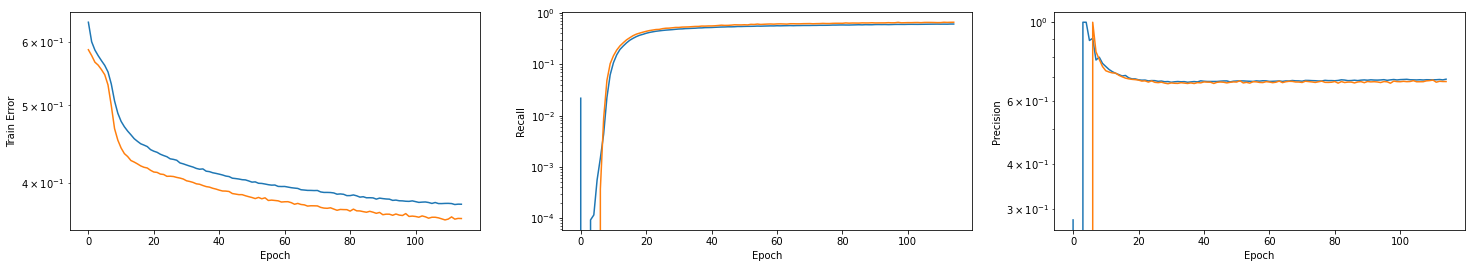

In [11]:
plt.figure(figsize=(25,4), facecolor='white')
plt.subplot(1,3,1)
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

plt.subplot(1,3,2)
pd.Series(history.history['recall']).plot(logy=True)
pd.Series(history.history['val_recall']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Recall")

plt.subplot(1,3,3)
pd.Series(history.history['precision']).plot(logy=True)
pd.Series(history.history['val_precision']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/metrics.png")
plt.show()

[[26102  3222]
 [ 3817  7035]]


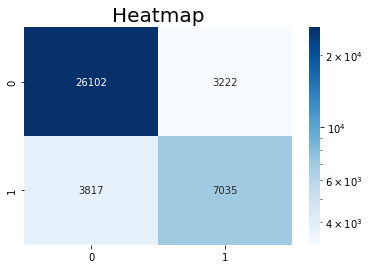

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

label_pre = model.predict([x_val, y_val])


# #Create confusion matrix and normalizes it over predicted (columns)
# label = np.argmax(label_val, axis = 1)

label_pre = np.round(label_pre,0)
result = confusion_matrix(label_val, label_pre)
print(result)

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
plt.figure(facecolor='white')
ax = sns.heatmap(result, annot=True,fmt='d',cmap='Blues',norm=LogNorm())
plt.title('Heatmap', fontsize=20)
plt.savefig(f"model/{created_time}_{loss}_{lr}_{batch_size}/heatmap.png")
plt.show()